#### (A) Super-Resolution: Superresolution on the image shown in notebook to enhance its resolution by factor 2. 
Qualitative comparison of original and reconstructed image

##### Necessary Imports

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import urllib.request

import numpy as np
import torch.nn as nn


from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

##### Target Image

In [2]:
file_path = 'dog.jpg'
if os.path.exists(file_path):
    print('dog.jpg exists')
else:
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    urllib.request.urlretrieve(url, file_path)

dog.jpg exists


In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


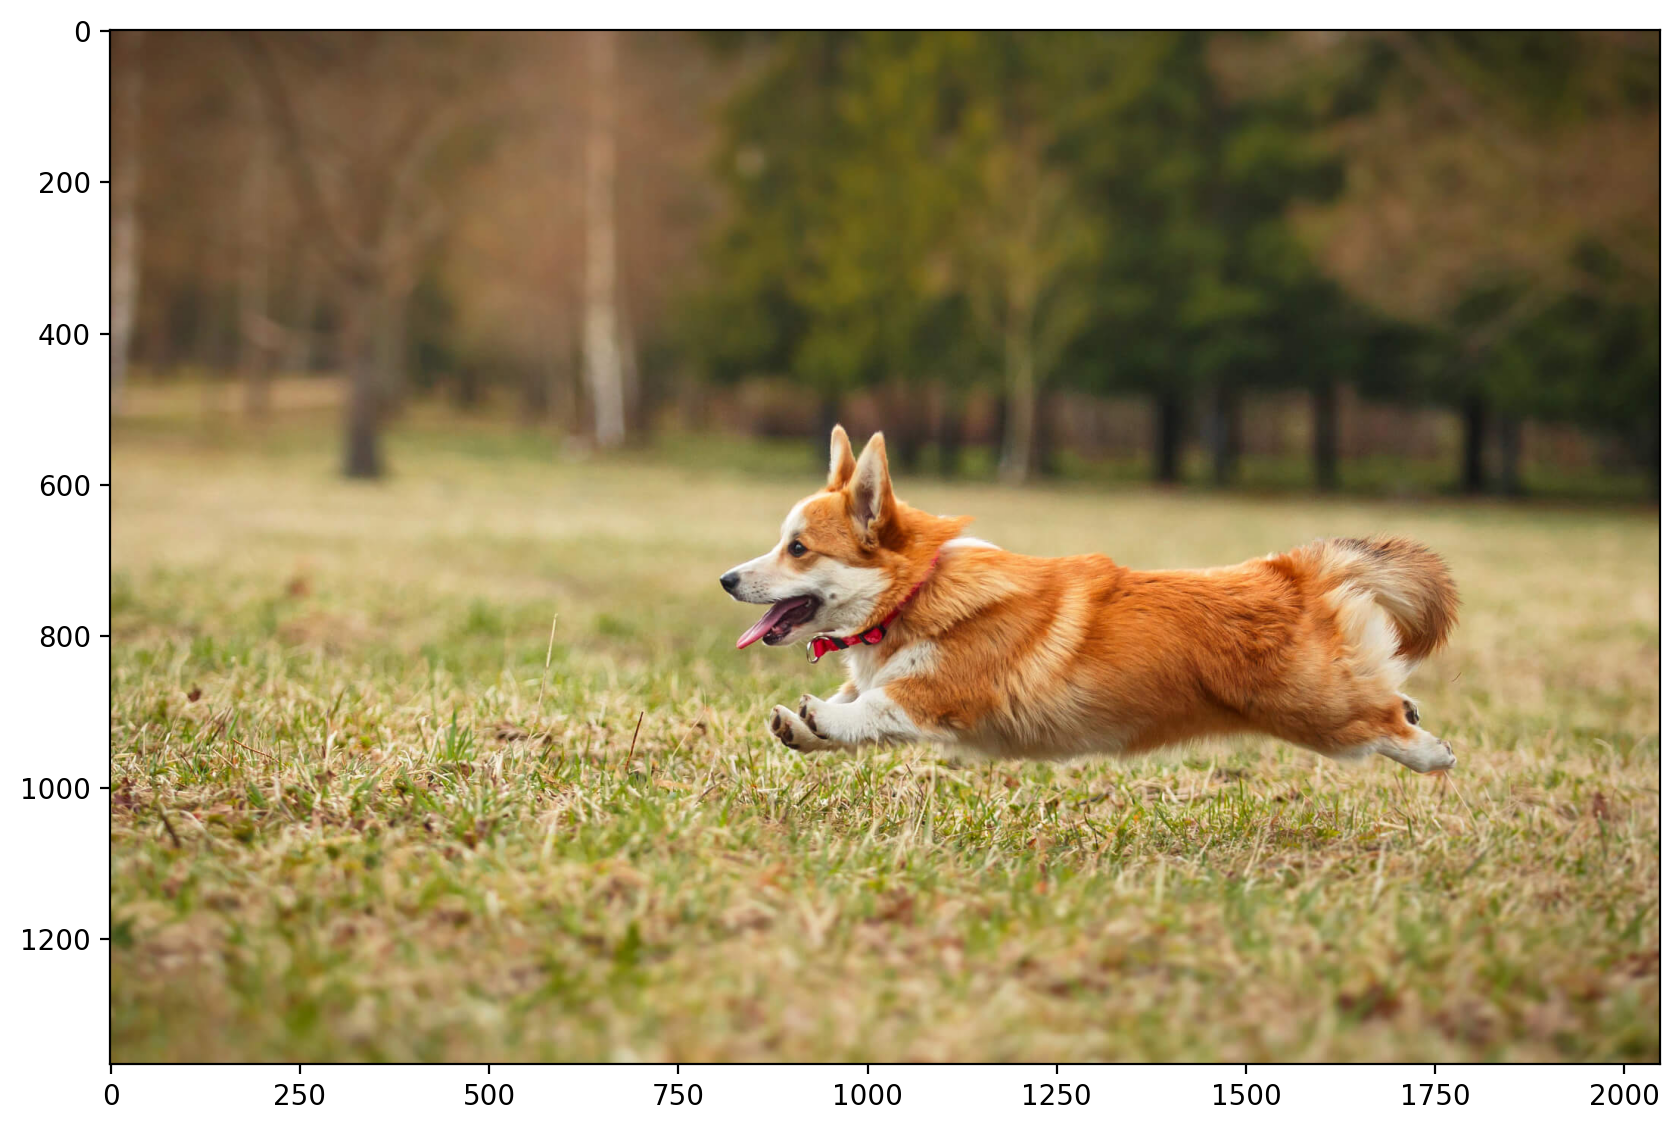

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

##### Scaling the Image RGB Values from $0$ to $1$ using the Min-Max Scaler

In [5]:
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler

MinMaxScaler()

In [6]:
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
print(scaled_img)

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.14

##### Cropping a 100 x 100 part of Image

In [7]:
OriginalImg = torchvision.transforms.functional.crop(scaled_img.cpu(), 700, 800, 100, 100)
print(OriginalImg.shape)

torch.Size([3, 100, 100])


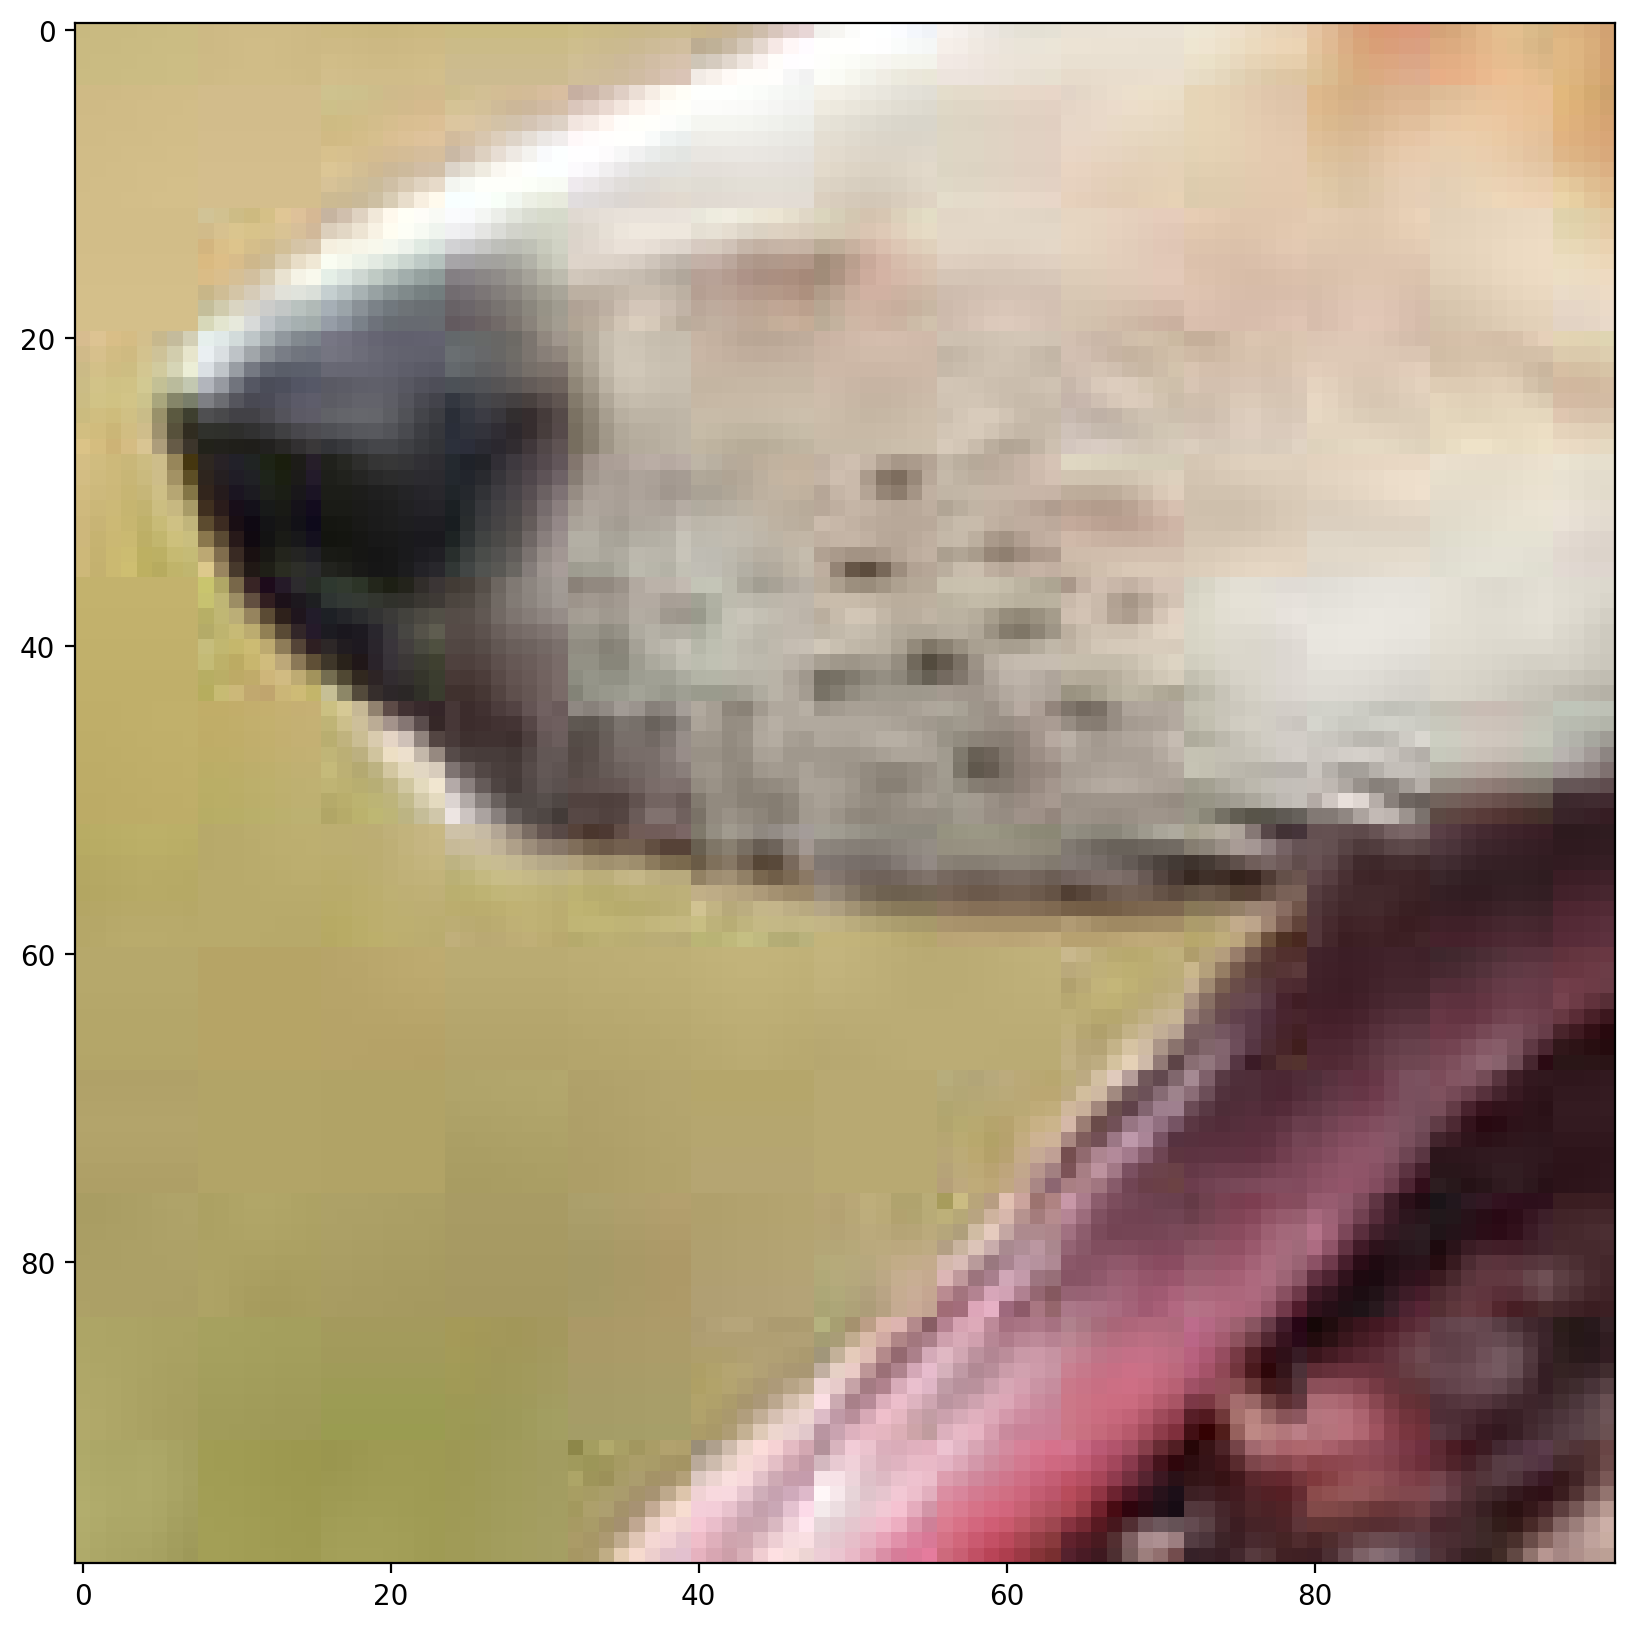

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(OriginalImg, 'c h w -> h w c').numpy())

##### Function for Creating the Coordinate Map for the Original Image (100 x 100 in this case)

In [9]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

##### Function for Training the Linear Model on the Random Fourier Features

In [10]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [11]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

##### Function for Plotting the Original Image & Enhanced Image ($100$ x $100$ & $200$ x $200$ in this case)

In [12]:
def plot_Original_vs_Enhanced_Img(OriginalImg, X_rff_enhanced, net, scale = 1, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_enhanced: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    scale: int
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    height *= scale
    width *= scale

    with torch.no_grad():
        outputs = net(X_rff_enhanced)
        enhanced_img = outputs.reshape(num_channels, height, width).to(device)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height//scale}x{width//scale})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Enhanced Image ({height}x{width})')
    ax1.imshow(enhanced_img.reshape(height,width,num_channels).cpu().detach().numpy())

    fig.suptitle('Original vs Enhanced Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    if(return_Output == 1):
        return enhanced_img


##### General Function for Enhancing the Image to Double Pixels

In [13]:
def doublePixels(image, num_features, sigma = 0.04, lr = 0.02, epochs = 1000, device = 'cpu'):

    """
    image: torch.Tensor of shape (num_channels, height, width)
    num_features: int
    sigma: float
    lr: float
    epochs: int
    device: str

    """
    import gc
    from sklearn import preprocessing
    from sklearn.kernel_approximation import RBFSampler

    X, Y = create_coordinate_map(image)
    Y = Y.to(device)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
    scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)

    rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
    X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)

    net = LinearModel(X_rff.shape[1],image.shape[0]).to(device)
    train(net, lr, X_rff, Y, epochs)

    del X_rff, X, Y, scaled_X, scaler
    gc.collect()

    X_, Y_ = create_coordinate_map(image,scale=2)

    scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
    scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)

    X_rff = torch.tensor(rff.transform(scaled_X_.cpu().numpy())).float().to(device)
    print("\nComparison Between Low Resolution Image and Enhanced Image:")
    EnImg = plot_Original_vs_Enhanced_Img(image, X_rff, net, scale = 2, return_Output = 1)
    del net, X_rff, X_, Y_, scaled_X_, scaler
    gc.collect()

    return EnImg

##### Enhancing the Image for Different Values of $\sigma$

Sigma = 0.1:
Training the Linear Model on the Low Resolution Image:
Epoch 0 loss: 0.392073
Epoch 100 loss: 0.002205
Epoch 200 loss: 0.002032
Epoch 300 loss: 0.001988

Comparison Between Low Resolution Image and Enhanced Image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


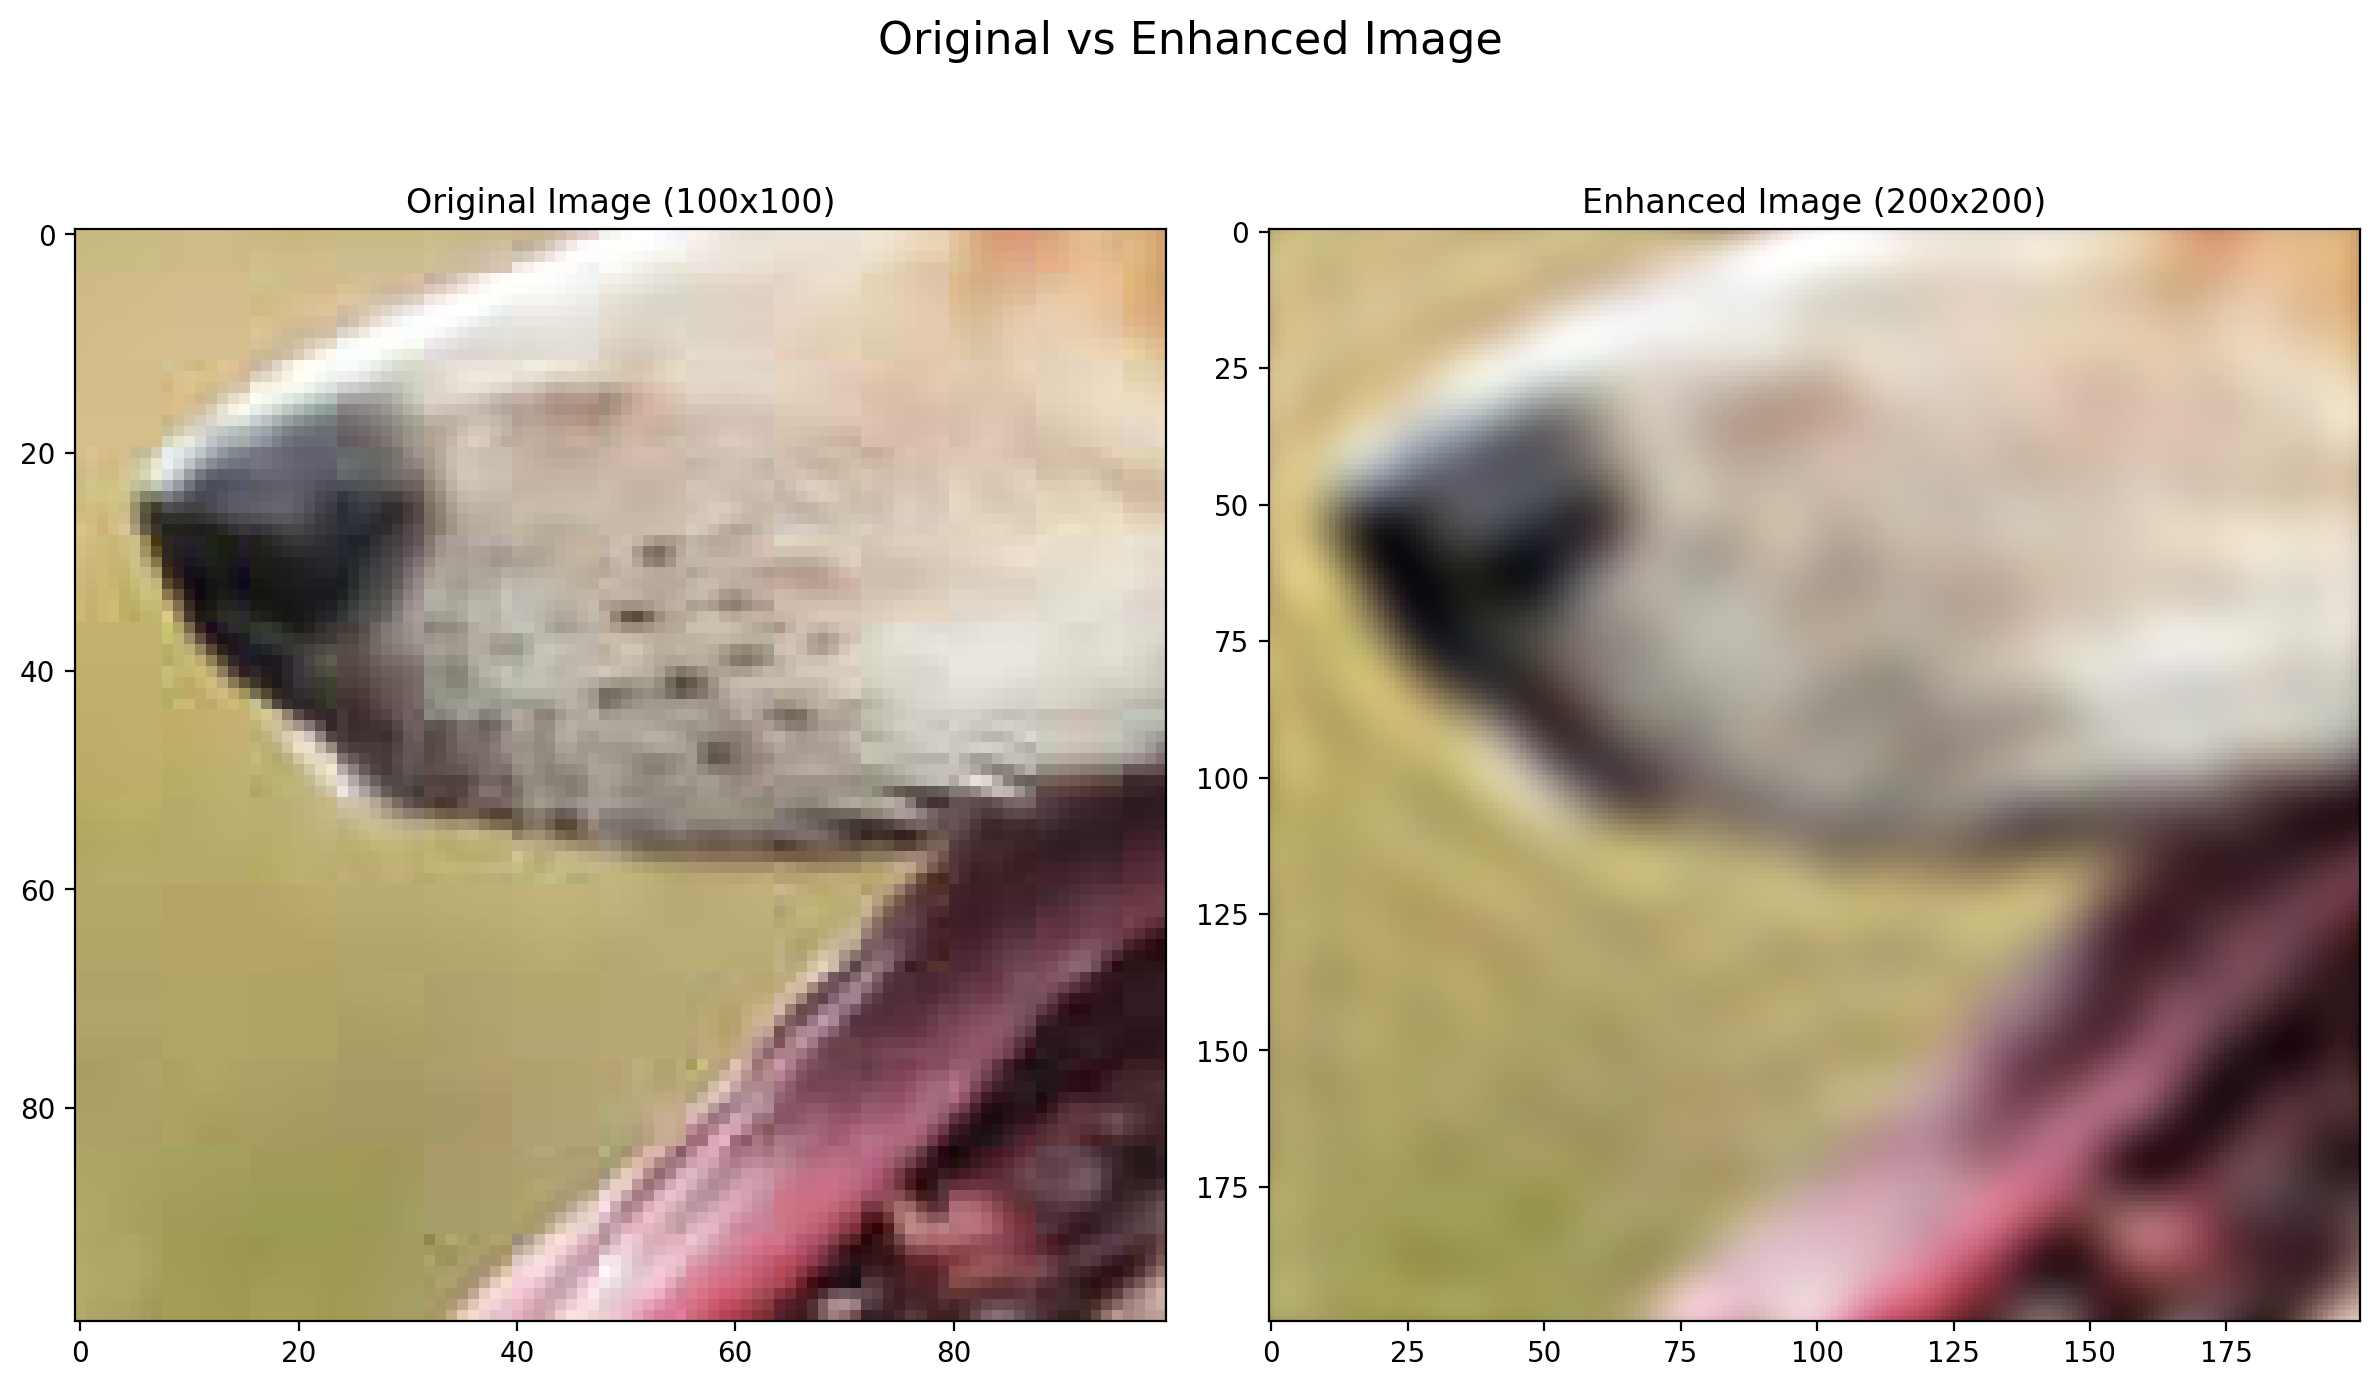

Sigma = 0.04:
Training the Linear Model on the Low Resolution Image:
Epoch 0 loss: 0.386672
Epoch 100 loss: 0.000748
Epoch 200 loss: 0.000585
Epoch 300 loss: 0.000540

Comparison Between Low Resolution Image and Enhanced Image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


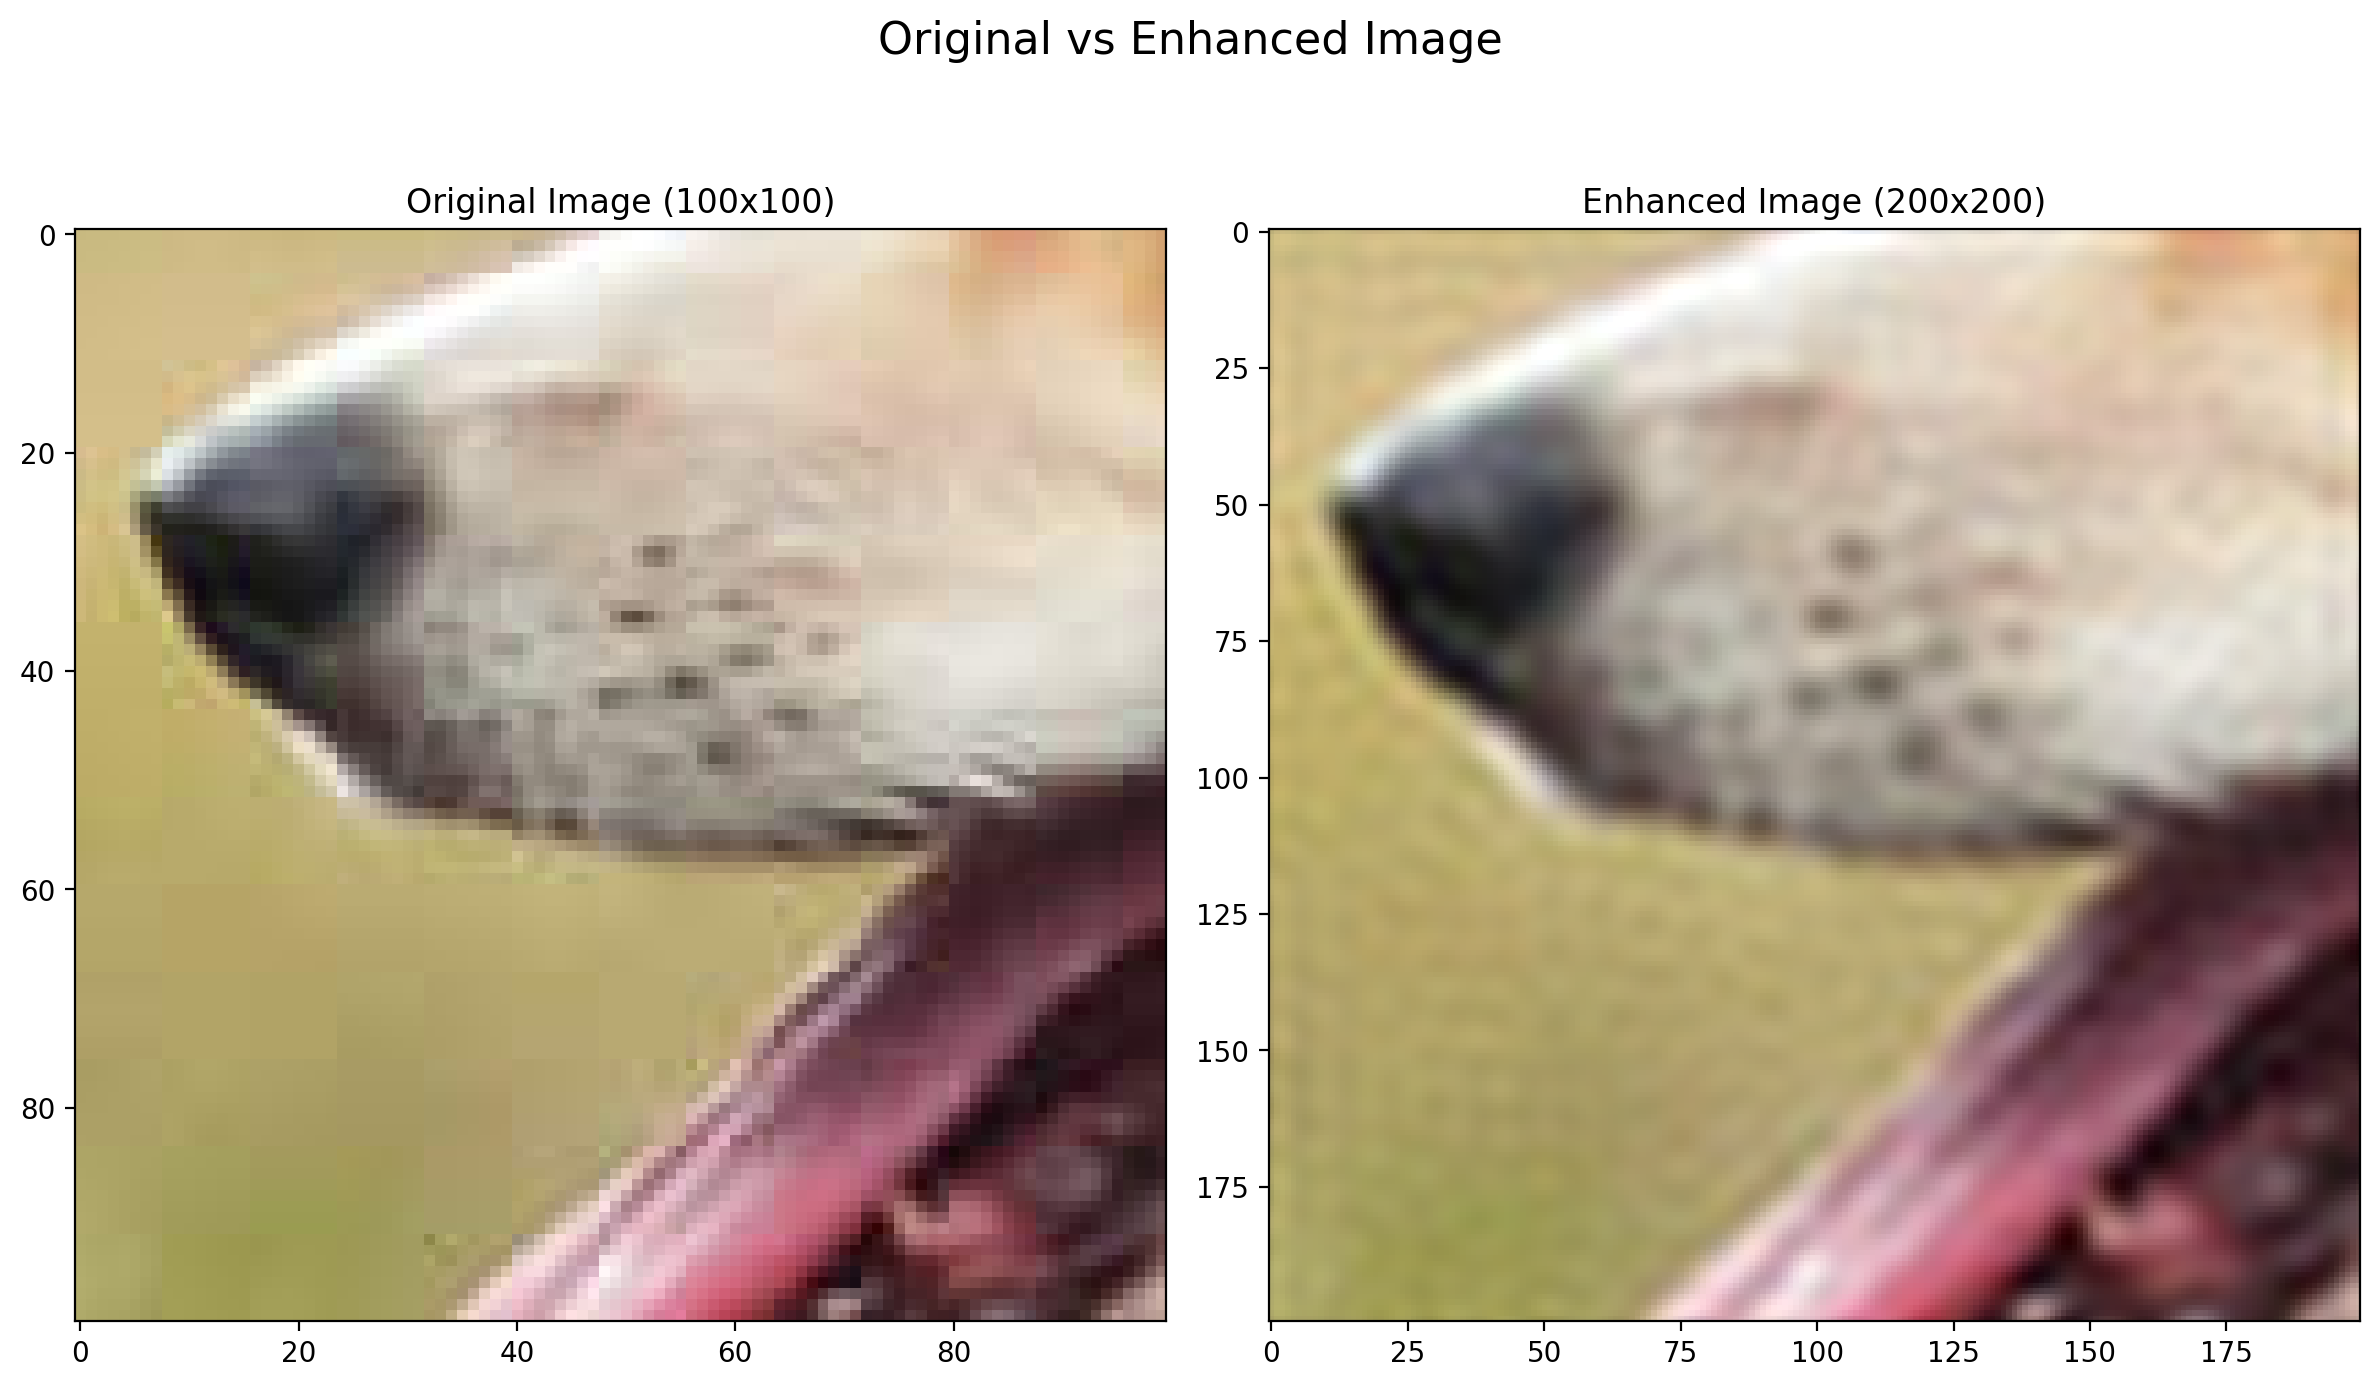

Sigma = 0.01:
Training the Linear Model on the Low Resolution Image:
Epoch 0 loss: 0.398626
Epoch 100 loss: 0.017538
Epoch 200 loss: 0.008029
Epoch 300 loss: 0.004246

Comparison Between Low Resolution Image and Enhanced Image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


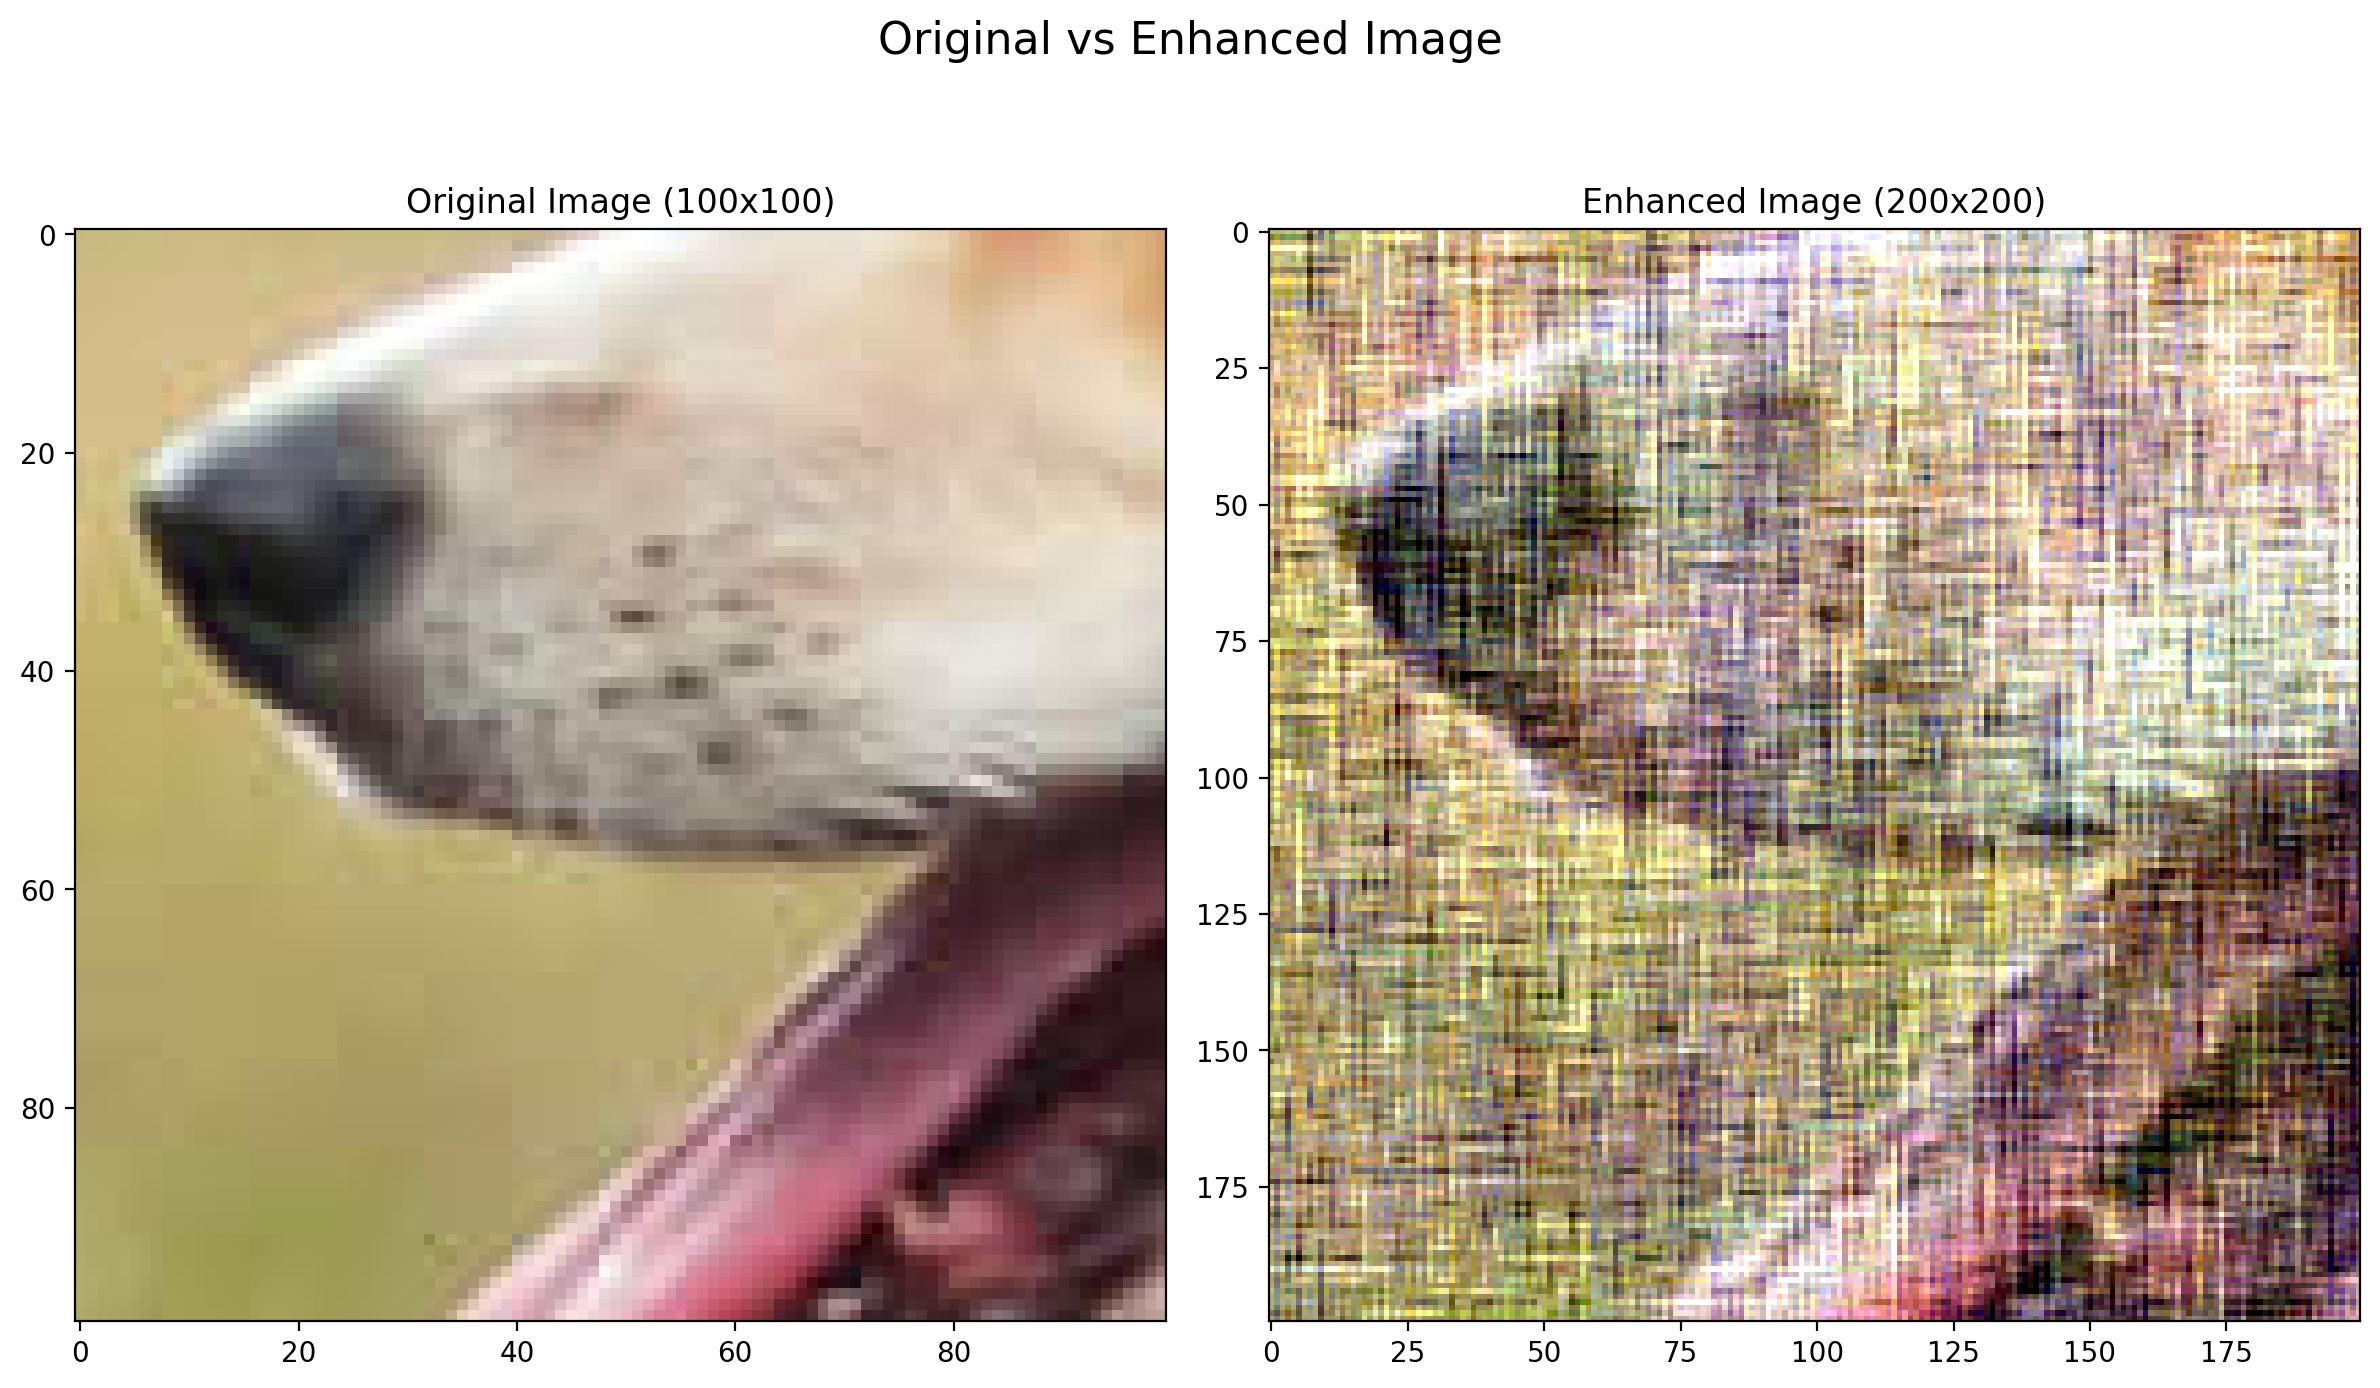

In [14]:
sigmas = [0.1,0.04,0.01]
EnImg = []
for sigma in sigmas:
  print(f"Sigma = {sigma}:\nTraining the Linear Model on the Low Resolution Image:")
  EnImg.append(doublePixels(OriginalImg,10000,sigma = sigma, epochs=300, lr=0.01))